# Optimization of Golinski function using PSO

This problem is characterized by 7 decision variables, 26 constraints (14 boundaries and 12 non linear constraints) and a cost function which is highly non linear.

To solve it, I decided to adopt the PSO algorithm.


I chose this algorithm because:

- I find its underlying working principle more intuitive than other methaeuristics  
- I understand that literature suggests already a range of values (around 1) for its 3 tuning parameters (inertia factor, self confidence, swarm confidence) to tests; of course there is no specific indication regarding the numbers of swarms to consider. 
- According to my (limited) experience this algorithm is fast (of course increasing the number of swarms it slows down) and efficient in finding the point of minimum

Specifically I used the PSO algorithm implemented in Python package pyswarm because it allows to easily manage both equality and inequality constraints, a quality much important given that we will have to manage 26 constraints in total. 
The drawback of this package is that the algorithm does not return as an output the values of the cost function at each iteration. Even enabling a higher debug level, it only prints on the screen the values of the cost function at each iteration, but this of course is not enough to draw a plot Cost Function VS iteration.

Due to the lack of time, I did not code my own PSO algorithm.


## Approach

My first target was to find a "good" value of the 4 parameters in PSO.
In light of that I tested all possible combinations of the below values:
- number of swarms: from 10 to 60 with steps of 10
- inertia factor: [0.5, 0.75, 1]
- self confidence: [0.5, 0.75, 1, 1.2, 1.5]
- swarm confidence: [0.5, 0.75, 1, 1.2, 1.5]

The range of values for the number of swarms to be tested was chosen arbitrary.
Regarding the remaining 3 parameters, I chose a compromise between values suggested by the author of the pyswarm library I used who suggested to use values between 0 and 1, and values written on slides shown in class which suggested values bigger than 1 for all parameters, in particular for the swarm confidence for which suggested values between 2 and 2.5.  
I limited the granularity of the grid to limit the number of combinations to be tested.


To identify the best combination of the above 4 parameters I launched 20 runs for each combination, each run consisting in PSO algorithm set to perform 500 iterations maximum.

For each combination I evaluated its success as the percentage of times (referring to 20 runs) the algorithm returned a value of the cost function lower than 3030.
I chose the threshold of 3030 because from slides I understand that a known solution of the prosble is 2985, and other PSO algorithms found 3019.


I then selected the 10 quadruplets that gave higher success rate, and run other 50 runs for each of them.
I used the success rate as metrics for this selection rather than looking at the parameters that gave the lowest value of the cost function because the 

I eventually chose the quadruplet that gave the best results and launch 100 runs. I evaluated the perfomances of this PSO algorithm using the outcome of this last set of runs.


## Conclusions

The procedure detailed in section APPROACH led to the following results on 100 runs: 

- Best Quadruplets of parameters:
    - Number of swarms: 60
    - Inertia factor: 0.75
    - Self confidence: 1.5
    - Swarm confidence: 1.5
    
    Given that for both the Self confidence and the Swarm Confidence the "best" values were the maximum ones that we tested (i.e. 1.5), it might be worth to test higher values and check whether this improves performances 

- Best Point of minimum:
 [ 3.5, 0.7, 17, 7.3, 7.71531993, 3.35021467, 5.28665447]

- Best Value of the cost Function : 2994.355027495922

- Time to execute the iteration which found the best value: 1.78125 seconds

- Success rate over 100 runs: 80%

- Average execution time: 1.8915625 seconds


In [2]:
import numpy as np
from pyswarm import pso
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from time import process_time

In [3]:
# Define the objective (to be minimize)
def Golinski(x, *args):
    
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args

    return (a * x1 * (x2**2) * (b * (x3**2) + c * x3 -d ) 
            - e * x1 * (x6**2 + x7**2 ) 
            + f * (x6**3 + x7**3 ) 
            + a * (x4 * (x6**2) + x5 * (x7**2) ))

# Constraint must be set in the form f(x)>= 0.0 

def G1(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - 27 * (1 / (x1 * (x2**2) * x3))

def G2(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - 397.5 * (1 / (x1 * (x2)**2 * (x3)**2))
    
def G3(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - 1.93 * (1 / (x2 * x3 * (x4**3) * (x6**4) ))
    
def G4(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - 1.93 * (1 / (x2 * x3 * (x5**3) * (x7**4) ))
    
def G5(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - np.sqrt( (745 * x4 * (1 /(x2 * x3) ) )**2 + 16.9 * (10**6) ) / (110.0 * (x6**3))
    
def G6(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - np.sqrt( (745 * x5 * (1 /(x2 * x3) ) )**2 + 157.5 * (10**6) ) / (85 * (x7**3))
    
def G7(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - (x2 * x3) / 40
     
def G8(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - 5 * x2 / x1
    
def G9(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - x1/(12 * x2)
    
def G10(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - (1.5 * x6 + 1.9) / x4

def G11(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - (1.1 * x7 + 1.9) / x5

def G12(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 1 - (1.5 * x6 + 1.9) / x4

def G13(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return x1 - 2.6

def G14(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 3.6 - x1

def G15(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return x2 - 0.7

def G16(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 0.8 - x2

def G17(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return x3 - 17

def G18(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 28 - x3

def G19(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return x4 - 7.3

def G20(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 8.3 - x4

def G21(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return x5 - 7.3

def G22(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 8.3 - x5

def G23(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return x6 - 2.9

def G24(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 3.9 - x6

def G25(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return x7 - 5.0

def G26(x, *args):
    x1, x2, x3, x4, x5, x6, x7 = x
    a, b, c, d, e, f = args
    return 5.9 - x7



# Setup the constraint functions

def constraints(x, *args):
    
    c1 = G1(x, *args)
    c2 = G2(x, *args)
    c3 = G3(x, *args)
    c4 = G4(x, *args)
    c5 = G5(x, *args)
    c6 = G6(x, *args)
    c7 = G7(x, *args)
    c8 = G8(x, *args)
    c9 = G9(x, *args)
    c10 = G10(x, *args)
    c11 = G11(x, *args)
    c12 = G12(x, *args)
    c13 = G13(x, *args)
    c14 = G14(x, *args)
    c15 = G15(x, *args)
    c16 = G16(x, *args)
    c17 = G17(x, *args)
    c18 = G18(x, *args)
    c19 = G19(x, *args)
    c20 = G20(x, *args)
    c21 = G21(x, *args)
    c22 = G22(x, *args)
    c23 = G23(x, *args)
    c24 = G24(x, *args)
    c25 = G25(x, *args)
    c26 = G26(x, *args)
    
    return [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22, c23, c24, c25, c26]

# Define the other parameters
a = 0.7854
b = 3.3333
c = 14.9334
d = 43.0934
e = 1.5079
f = 7.477

args = (a, b, c, d, e, f)

# Define the lower and upper bounds for H, d, t, respectively
lb = [2.6, 0.7, 17, 7.3, 7.3, 2.9, 5.0]
ub = [3.6, 0.8, 28, 8.3, 8.3, 3.9, 5.9]


In [2]:
# swarmsize : int
# The number of particles in the swarm (Default: 100)

# omega : scalar
# Particle velocity scaling factor (Default: 0.5)

# phip : scalar
# Scaling factor to search away from the particle’s best known position (Default: 0.5)

# phig : scalar
# Scaling factor to search away from the swarm’s best known position (Default: 0.5)

# maxiter : int
# The maximum number of iterations for the swarm to search (Default: 100)

# minstep : scalar
# The minimum stepsize of swarm’s best position before the search terminates (Default: 1e-8)

# minfunc : scalar
# The minimum change of swarm’s best objective value before the search terminates (Default: 1e-8)

# debug : boolean
# If True, progress statements will be displayed every iteration (Default: False)

In [3]:
xopt, fopt = pso(Golinski, lb, ub, f_ieqcons=constraints, args=args, maxiter = 1000, swarmsize = 60, phip = 1, phig = 1)

print("Point found by the algo: {0}".format(xopt))

print("Value of the cost function: {0}".format(fopt))

Stopping search: maximum iterations reached --> 1000
However, the optimization couldn't find a feasible design. Sorry
Point found by the algo: [ 2.96803198  0.75562321 19.52114389  7.75549978  7.44628517  3.47666489
  5.38101447]
Value of the cost function: 1e+100


In [4]:
# Cosa lancio:
#     - per ogni valore di 
#         swarmsize = range(1,61,5)
#         phip = range(0.2, 1, 0.1)
#         phig = range(0.2, 1, 0.1)

#     COnsidero un fallimento ogni valore di fopt > 4000
    
# Cosa voglio ottenere:

# - percentuale di successo su 100 run per ogni valore del trio swarmsize phip phig 
#     --> per ogni 100 run conta numero di successi 
# - miglior punto di minimo e relativo valore di FCost per ogni 100 run

# 4 liste:
#     1) tripletta swarmsize phip phig 
#     2) percentuale di successo su 100 run con tripletta sopra
#     3) miglior punto di minimo trovato in 100 run
#     4) corrispondente valore di FCost

In [5]:
#Number of particles
swarmSizePoints = [i for i in range(10,61,10)]

# phip : scalar
# Scaling factor to search away from the particle’s best known position (Default: 0.5) - i.e. self confidence
phipPoints = [0.5, 0.75, 1]

# phig : scalar
# Scaling factor to search away from the swarm’s best known position (Default: 0.5) - i.e. swarm confidence
phigPoints = [0.5, 0.75, 1]

# omega : scalar
# Inertia factor
omegaPoints = [0.5, 0.75, 1]



maxrun = 20
StoryXopt = list()
StoryFopt = list()
StoryParam = list()
StorySuccess = list() 

for ss in swarmSizePoints:
    
    for om in omegaPoints:
        
        for pp in phipPoints:

            for pg in phigPoints:

                CountSuccesTemp = 0

                for count in range(maxrun):

                    xoptTemp, foptTemp = pso(Golinski, lb, ub, f_ieqcons=constraints, args=args, maxiter = 500, swarmsize = ss, omega = om, phip = pp, phig = pg)

                    if foptTemp < 3030:

                        CountSuccesTemp = CountSuccesTemp +1 

                    if count == 0:

                        FValMinTemp = foptTemp
                        XValMinTemp = xoptTemp

                    elif foptTemp < FValMinTemp:

                        FValMinTemp = foptTemp
                        XValMinTemp = xoptTemp


                
                StoryXopt.append(XValMinTemp)
                StoryFopt.append(FValMinTemp)
                StoryParam.append([ss, om, pp, pg])
                StorySuccess.append(CountSuccesTemp/maxrun) 
    
    

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stop

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the

Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
S

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
S

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum 

Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, 

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, 

Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, 

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimiza

Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Howe

Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations re

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the opti

Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping searc

Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optim

Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations re

Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping sea

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, 

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, 

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the o

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimizat

Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stop

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping sea

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stop

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Sto

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iteration

Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping sea

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the

Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stop

Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorr

Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best objective change less than 

Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
Stopping sea

<Figure size 864x360 with 0 Axes>

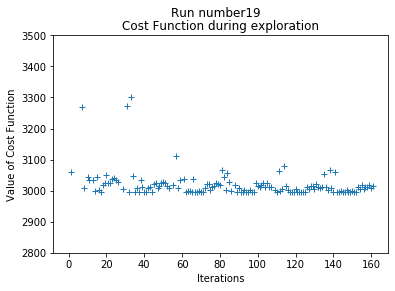

In [6]:
plt.figure(figsize=(12, 5))
fig, ax1 = plt.subplots(1)
fig.suptitle("Run number" + str(count))

ax1.set(xlabel="Iterations",ylabel="Value of Cost Function", title="Cost Function during exploration")

#axes.set_xlim([xmin,xmax])
ax1.set_ylim([2800,3500])

ax1.plot(StoryFopt,'+')   




In [7]:
# Stopping search: Swarm best position change less than 1e-08
# Point found by the algo: [ 3.59906512  0.7139451  17.          7.96549566  8.01498147  3.50264406
#   5.4802273 ]
# Value of the cost function: 3279.825077550767

In [8]:
# swarmsize : int
# The number of particles in the swarm (Default: 100)

# omega : scalar
# Particle velocity scaling factor (Default: 0.5)

# phip : scalar
# Scaling factor to search away from the particle’s best known position (Default: 0.5)

# phig : scalar
# Scaling factor to search away from the swarm’s best known position (Default: 0.5)

# maxiter : int
# The maximum number of iterations for the swarm to search (Default: 100)

# minstep : scalar
# The minimum stepsize of swarm’s best position before the search terminates (Default: 1e-8)

# minfunc : scalar
# The minimum change of swarm’s best objective value before the search terminates (Default: 1e-8)

# debug : boolean
# If True, progress statements will be displayed every iteration (Default: False)

In [19]:
# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('EX3_PSO_part1.pkl', 'wb') as f:
    pickle.dump([StoryXopt,StoryFopt,StoryParam,StorySuccess], f)

In [4]:
with open('EX3_PSO_part1.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    StoryXopt,StoryFopt,StoryParam,StorySuccess = pickle.load(f)

In [5]:
with open('EX3_PSO_part2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    StoryXopt2,StoryFopt2,StoryParam2,StorySuccess2 = pickle.load(f)

In [6]:
finalParam = StoryParam + StoryParam2
finalFVal = StoryFopt + StoryFopt2
finalXVal = StoryXopt + StoryXopt2
finalSucces = StorySuccess + StorySuccess2

In [7]:
DF2 = pd.DataFrame({"Parameters":finalParam, "CostF":finalFVal, "SuccessRate":finalSucces, "XVal":finalXVal})


In [8]:
DF2["NSwarm"] = DF2.apply(lambda row: row.Parameters[0] , axis=1)
DF2["Inertia"] = DF2.apply(lambda row: row.Parameters[1] , axis=1)
DF2["SelfConf"] = DF2.apply(lambda row: row.Parameters[2] , axis=1)
DF2["SwarmConf"] = DF2.apply(lambda row: row.Parameters[3] , axis=1)

In [9]:
DF2

,Parameters,CostF,SuccessRate,XVal,NSwarm,Inertia,SelfConf,SwarmConf
0,"[10, 0.5, 0.5, 0.5]",4109.856479,0.00,"[3.503581308737373, 0.7, 20.27629133699746, 8....",10,0.50,0.50,0.50
1,"[10, 0.5, 0.5, 0.75]",3058.688473,0.00,"[3.597188135617172, 0.7, 17.0, 8.2142820941037...",10,0.50,0.50,0.75
2,"[10, 0.5, 0.5, 1]",5081.948913,0.00,"[3.5425703210213078, 0.7073548423428058, 25.61...",10,0.50,0.50,1.00
3,"[10, 0.5, 0.75, 0.5]",4311.783655,0.00,"[3.577284194639295, 0.715449957586325, 22.3570...",10,0.50,0.75,0.50
4,"[10, 0.5, 0.75, 0.75]",5443.292596,0.00,"[3.5912713428220995, 0.715314411310737, 26.344...",10,0.50,0.75,0.75
...,...,...,...,...,...,...,...,...
229,"[60, 0.75, 1.5, 1.5]",2994.355032,0.80,"[3.500000009013549, 0.7, 17.0, 7.3, 7.71531994...",60,0.75,1.50,1.50
230,"[60, 1, 1.2, 1.2]",3005.378850,0.55,"[3.5099420655045583, 0.7, 17.0, 7.302878822463...",60,1.00,1.20,1.20
231,"[60, 1, 1.2, 1.5]",3014.067252,0.40,"[3.5091635697014993, 0.7, 17.0, 7.709764596101...",60,1.00,1.20,1.50
232,"[60, 1, 1.5, 1.2]",3017.660122,0.35,"[3.5223430151116584, 0.7, 17.0, 8.3, 7.8771172...",60,1.00,1.50,1.20


In [10]:
#Sum of the success rate for each NSwarm --> 60 swarm seems to be a good number
DF2.groupby("NSwarm").sum()["SuccessRate"]

NSwarm
10     1.80
20     4.60
30     8.00
40     9.30
50    11.75
60    13.70
Name: SuccessRate, dtype: float64

In [11]:
# NSwarm = 60 has the highest value of success rate
DF2.groupby("NSwarm")["SuccessRate"].max()

NSwarm
10    0.40
20    0.45
30    0.70
40    0.70
50    0.80
60    0.85
Name: SuccessRate, dtype: float64

In [46]:
DF2.sort_values(by = "CostF", ascending = True).head(10)

,Parameters,CostF,SuccessRate,XVal,NSwarm,Inertia,SelfConf,SwarmConf
204,"[40, 0.75, 1.5, 1.2]",2994.355027,0.50,"[3.5000000000548304, 0.7, 17.0, 7.3, 7.7153199...",40,0.75,1.50,1.2
98,"[40, 0.75, 1, 1]",2994.355027,0.40,"[3.5000000003924283, 0.7, 17.0, 7.3, 7.7153199...",40,0.75,1.00,1.0
214,"[50, 0.75, 1.2, 1.2]",2994.355027,0.45,"[3.500000000004591, 0.7, 17.0, 7.3, 7.71531993...",50,0.75,1.20,1.2
224,"[60, 0.5, 1.5, 1.2]",2994.355027,0.65,"[3.5000000005527445, 0.7, 17.0, 7.3, 7.7153199...",60,0.50,1.50,1.2
217,"[50, 0.75, 1.5, 1.5]",2994.355028,0.80,"[3.500000000705907, 0.7, 17.0, 7.3, 7.71531992...",50,0.75,1.50,1.5
223,"[60, 0.5, 1.2, 1.5]",2994.355028,0.50,"[3.5000000003930705, 0.7, 17.0, 7.3, 7.7153199...",60,0.50,1.20,1.5
146,"[60, 0.75, 0.5, 1]",2994.355028,0.20,"[3.5000000021485396, 0.7, 17.0, 7.3, 7.7153199...",60,0.75,0.50,1.0
122,"[50, 0.75, 0.75, 1]",2994.355028,0.55,"[3.5000000035145202, 0.7, 17.0, 7.3, 7.7153199...",50,0.75,0.75,1.0
68,"[30, 0.75, 0.75, 1]",2994.355029,0.25,"[3.50000000123208, 0.7, 17.0, 7.3, 7.715319921...",30,0.75,0.75,1.0
95,"[40, 0.75, 0.75, 1]",2994.355029,0.20,"[3.5000000047694586, 0.7, 17.0, 7.3, 7.7153199...",40,0.75,0.75,1.0


In [14]:
DFFocusBest = DF2.sort_values(by = "SuccessRate", ascending = False).head(10)
DFFocusBest

,Parameters,CostF,SuccessRate,XVal,NSwarm,Inertia,SelfConf,SwarmConf
226,"[60, 0.75, 1.2, 1.2]",2994.355030,0.85,"[3.5000000007866046, 0.7, 17.0, 7.3, 7.7153199...",60,0.75,1.2,1.2
229,"[60, 0.75, 1.5, 1.5]",2994.355032,0.80,"[3.500000009013549, 0.7, 17.0, 7.3, 7.71531994...",60,0.75,1.5,1.5
217,"[50, 0.75, 1.5, 1.5]",2994.355028,0.80,"[3.500000000705907, 0.7, 17.0, 7.3, 7.71531992...",50,0.75,1.5,1.5
216,"[50, 0.75, 1.5, 1.2]",2994.355031,0.70,"[3.500000003586188, 0.7, 17.0, 7.3, 7.71531996...",50,0.75,1.5,1.2
201,"[40, 0.5, 1.5, 1.5]",2994.355030,0.70,"[3.500000002520373, 0.7, 17.0, 7.3, 7.71531996...",40,0.50,1.5,1.5
193,"[30, 0.75, 1.5, 1.5]",2994.355029,0.70,"[3.5000000023610105, 0.7, 17.0, 7.3, 7.7153199...",30,0.75,1.5,1.5
205,"[40, 0.75, 1.5, 1.5]",2994.355031,0.65,"[3.5000000013396355, 0.7, 17.0, 7.3, 7.7153199...",40,0.75,1.5,1.5
228,"[60, 0.75, 1.5, 1.2]",2994.355029,0.65,"[3.5000000003909713, 0.7, 17.0, 7.3, 7.7153199...",60,0.75,1.5,1.2
224,"[60, 0.5, 1.5, 1.2]",2994.355027,0.65,"[3.5000000005527445, 0.7, 17.0, 7.3, 7.7153199...",60,0.50,1.5,1.2
225,"[60, 0.5, 1.5, 1.5]",2994.355030,0.60,"[3.5000000007656755, 0.7, 17.0, 7.3, 7.7153199...",60,0.50,1.5,1.5


In [17]:
swarmSizePoints = list(DFFocusBest["NSwarm"])
omegaPoints = list(DFFocusBest["Inertia"])
phipPoints = list(DFFocusBest["SelfConf"])
phigPoints = list(DFFocusBest["SwarmConf"])

In [18]:
maxrun = 50
StoryXopt60 = list()
StoryFopt60 = list()
StoryParam60 = list()
StorySuccess60 = list() 


for r in range(len(omegaPoints)):
    ss = swarmSizePoints[r]
    om = omegaPoints[r]
    pp = phipPoints[r]
    pg = phigPoints[r]
    
    CountSuccesTemp = 0

    for count in range(maxrun):

        xoptTemp, foptTemp = pso(Golinski, lb, ub, f_ieqcons=constraints, args=args, maxiter = 500, swarmsize = ss, omega = om, phip = pp, phig = pg)

        if foptTemp < 3030:

            CountSuccesTemp = CountSuccesTemp +1 

        if count == 0:

            FValMinTemp = foptTemp
            XValMinTemp = xoptTemp

        elif foptTemp < FValMinTemp:

            FValMinTemp = foptTemp
            XValMinTemp = xoptTemp



    StoryXopt60.append(XValMinTemp)
    StoryFopt60.append(FValMinTemp)
    StoryParam60.append([ss, om, pp, pg])
    StorySuccess60.append(CountSuccesTemp/maxrun) 


Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position chang

Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
Stopping search: Swarm best objective change less than 1e-08
Stop

Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible des

Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. 

Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
However, the optimization couldn't find a feasible design. Sorry
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change l

In [19]:
DFZoom = pd.DataFrame({"Parameters":StoryParam60, "CostF":StoryFopt60, "SuccessRate":StorySuccess60, "XVal":StoryXopt60})

In [21]:
DFZoom.sort_values(by = "SuccessRate", ascending = False)

,Parameters,CostF,SuccessRate,XVal
1,"[60, 0.75, 1.5, 1.5]",2994.355029,0.76,"[3.500000002184168, 0.7, 17.0, 7.3, 7.71531996..."
2,"[50, 0.75, 1.5, 1.5]",2994.355028,0.74,"[3.500000002040444, 0.7, 17.0, 7.3, 7.71531993..."
0,"[60, 0.75, 1.2, 1.2]",2994.355028,0.70,"[3.5000000029883376, 0.7, 17.0, 7.3, 7.7153199..."
9,"[60, 0.5, 1.5, 1.5]",2994.355027,0.64,"[3.5000000008556253, 0.7, 17.0, 7.3, 7.7153199..."
3,"[50, 0.75, 1.5, 1.2]",2994.355027,0.62,"[3.5000000004905845, 0.7, 17.0, 7.3, 7.7153199..."
7,"[60, 0.75, 1.5, 1.2]",2994.355028,0.62,"[3.5000000010748207, 0.7, 17.0, 7.3, 7.7153199..."
6,"[40, 0.75, 1.5, 1.5]",2994.355032,0.54,"[3.5000000013418804, 0.7, 17.0, 7.3, 7.7153199..."
5,"[30, 0.75, 1.5, 1.5]",2994.355029,0.48,"[3.5000000041925676, 0.7, 17.0, 7.3, 7.7153199..."
8,"[60, 0.5, 1.5, 1.2]",2994.355028,0.48,"[3.500000001075601, 0.7, 17.0, 7.3, 7.71531991..."
4,"[40, 0.5, 1.5, 1.5]",2994.355032,0.44,"[3.500000008819316, 0.7, 17.0, 7.3, 7.71532000..."


In [22]:
with open('EX3_PSO_zoom60.pkl', 'wb') as f:
    pickle.dump([DFZoom], f)

In [23]:
DFZoom[DFZoom["SuccessRate"] == DFZoom["SuccessRate"].max()]

,Parameters,CostF,SuccessRate,XVal
1,"[60, 0.75, 1.5, 1.5]",2994.355029,0.76,"[3.500000002184168, 0.7, 17.0, 7.3, 7.71531996..."


In [24]:
StoryXopt = list()
StoryFopt = list()
StoryTime = list()

for count in range(100):
        start= process_time()
        xoptTemp, foptTemp = pso(Golinski, lb, ub, f_ieqcons=constraints, args=args, maxiter = 500, swarmsize = 60, omega = 0.75, phip = 1.5, phig = 1.5)
        end= process_time()
        
        StoryXopt.append(xoptTemp)
        StoryFopt.append(foptTemp)
        
        time = (end-start)
        StoryTime.append(time)


Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 500
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less than 1e-08
Stopping search: Swarm best position change less

In [33]:
DFFinalResult = pd.DataFrame({"CostF":StoryFopt, "Time":StoryTime, "XVal":StoryXopt})

In [34]:
DFFinalResult

,CostF,Time,XVal
0,2994.355039,2.093750,"[3.500000000135248, 0.7, 17.0, 7.3, 7.71532023..."
1,2994.355041,1.468750,"[3.500000000719002, 0.7, 17.0, 7.3, 7.71532017..."
2,2994.355035,1.812500,"[3.500000000782906, 0.7, 17.0, 7.3, 7.71532002..."
3,2994.355043,1.921875,"[3.5000000163824256, 0.7, 17.0, 7.3, 7.7153201..."
4,2994.355040,2.031250,"[3.5000000069038992, 0.7, 17.0, 7.3, 7.7153203..."
...,...,...,...
95,2994.355033,1.984375,"[3.5000000025841325, 0.7, 17.0, 7.3, 7.7153200..."
96,3033.632902,1.625000,"[3.6, 0.7, 17.0, 7.3, 7.715319934935955, 3.350..."
97,3003.688896,2.015625,"[3.5000000355680263, 0.7, 17.0, 8.3, 7.7153212..."
98,2994.355063,1.562500,"[3.5000000098437685, 0.7, 17.0, 7.3, 7.7153201..."


In [27]:
with open('EX3_PSO_Final.pkl', 'wb') as f:
    pickle.dump([DFFinalResult], f)

In [12]:
with open('EX3_PSO_Final.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    DFFinalResult = pickle.load(f)

In [35]:
BestResult=DFFinalResult[ DFFinalResult["CostF"] == DFFinalResult["CostF"].min() ]

In [36]:
BestPointX = BestResult["XVal"]
BestFunc = BestResult["CostF"]

In [37]:
TimeBest = BestResult["Time"]

In [38]:
BestPointX

48    [3.500000000208644, 0.7, 17.0, 7.3, 7.71531992...
Name: XVal, dtype: object

In [40]:
print("The best Point of minimum is:\n {0}".format(BestPointX.loc[48]))

The best Point of minimum is:
 [ 3.5         0.7        17.          7.3         7.71531993  3.35021467
  5.28665447]


In [41]:
print("The best minimum is:\n {0}".format(BestFunc.loc[48]))

The best minimum is:
 2994.355027495922


In [42]:
print("The best minimum was found in {0} seconds".format(TimeBest.loc[48]))

The best minimum was found in 1.78125 seconds


In [43]:
DFFinalResult[DFFinalResult["CostF"] <= 3030].count()

CostF    80
Time     80
XVal     80
dtype: int64

In [44]:
DFFinalResult["Time"].mean()

1.8915625